In [1]:
import os, os.path as osp
import numpy as np
import torch
import torch.nn as nn
import torch.functional as F
import cv2
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace


/home/ayush/projects/nerf/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root = "../assets/fox"
device = 'cuda'

# Let's load the data. 

1. Our data is in RGBA format. It has its associated pose params. <br>
2. We have two types of pose params: intrinsics (for the camera) and extrinsics (amera to world) params.

In [3]:
! ls {root}/train
    

intrinsics  pose


In [4]:
fimgs = os.listdir( osp.join(root, "imgs"))
fimgs = [f for f in fimgs if "train" in f] # only training images
fimgs = [osp.join(osp.join(root, "imgs"), f) for f in fimgs if f.endswith('.png')] # check ig a png image
fimgs = sorted([osp.abspath(f) for f in fimgs]) # sort in order of id

fposes = os.listdir(osp.join(root, 'train/pose'))
fposes = [osp.join(osp.join(root, 'train/pose'), f) for f in fposes if f.endswith('.txt')]
fposes = sorted([osp.abspath(f) for f in fposes])

fintrinsics = os.listdir(osp.join(root, 'train/intrinsics'))
fintrinsics = [osp.join(osp.join(root, 'train/intrinsics'), f) for f in fintrinsics if f.endswith('.txt')]
fintrinsics = sorted([osp.abspath(f) for f in fintrinsics])

In [5]:
fimgs[0:3], fposes[0:3], fintrinsics[0:3]

(['/home/ayush/projects/nerf/assets/fox/imgs/train_0.png',
  '/home/ayush/projects/nerf/assets/fox/imgs/train_1.png',
  '/home/ayush/projects/nerf/assets/fox/imgs/train_10.png'],
 ['/home/ayush/projects/nerf/assets/fox/train/pose/train_0.txt',
  '/home/ayush/projects/nerf/assets/fox/train/pose/train_1.txt',
  '/home/ayush/projects/nerf/assets/fox/train/pose/train_10.txt'],
 ['/home/ayush/projects/nerf/assets/fox/train/intrinsics/train_0.txt',
  '/home/ayush/projects/nerf/assets/fox/train/intrinsics/train_1.txt',
  '/home/ayush/projects/nerf/assets/fox/train/intrinsics/train_10.txt'])

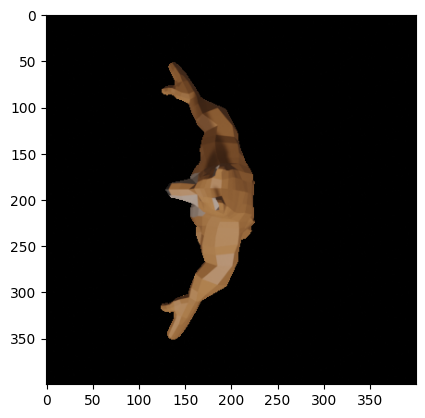

In [6]:
im = cv2.imread('/home/ayush/projects/nerf/assets/fox/imgs/train_0.png', cv2.IMREAD_UNCHANGED)
im = cv2.cvtColor(im, cv2.COLOR_BGRA2RGBA)
plt.imshow(im[..., :3])

In [7]:
read_txt = lambda x: np.array(open(x, 'r').readlines(), dtype=float).reshape(4,4)  # we read a txt file--> split it into lines --> parse it as numpy array --> reshape it to 4,4

def parse_data(fimgs, fposes, fintrinsics, device='cpu'):
    
    id1 = [im.split("/")[-1].split(".png")[0] for im in fimgs]
    # read an image in BGRA --> remove A channel by multiplying to RGB channels --> normalize the image to -1, 1
    imgs = [cv2.imread(im, cv2.IMREAD_UNCHANGED) for im in fimgs] ## RGBA
    imgs = [cv2.cvtColor(im, cv2.COLOR_BGRA2RGBA) for im in imgs]

    imgs = np.array(imgs) / 255.  # normalizing the image
    if imgs.shape[3] == 4: ## RGBA --> RGB
        imgs = imgs[...,:3] * imgs[...,-1:] + (1 - imgs[..., -1:])
    N = len(imgs)
    
    id2 = [f.split("/")[-1].split(".txt")[0] for f in fposes]
    poses = [read_txt(f) for f in fposes]
    poses = np.array(poses)
    assert len(poses) == N, "Images and pose numbers dont match"
    
    id3 = [f.split("/")[-1].split(".txt")[0] for f in fintrinsics]
    intrinsics = [read_txt(f) for f in fintrinsics]
    intrinsics = np.array(intrinsics)
    assert len(intrinsics) == N, "Images and intrinsics numbers dont match"
    
    print(imgs.shape, poses.shape, intrinsics.shape)
    for i1, i2, i3 in zip(id1, id2, id3):
        assert i1 == i2 == i3
    return imgs, poses, intrinsics

            
imgs, poses, intrinsics = parse_data(fimgs, fposes, fintrinsics)
H = imgs.shape[1]
W = imgs.shape[2]
print(f"Height: {H} & Width: {W}")

(90, 400, 400, 3) (90, 4, 4) (90, 4, 4)
Height: 400 & Width: 400


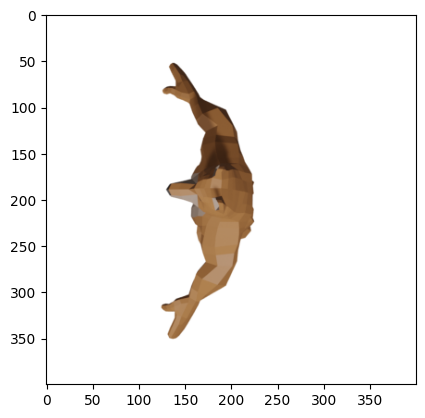

In [8]:
plt.imshow(imgs[0])

## Lets' make rays emanating from the optical center of the camera

<img src="../assets/pinhole_model.jpeg" alt="Image" width="600">

**Few changes**:
1. We have *image centers which are not aligned to perfect 0,0*.<br>
2. We have *fx, fy* instead of one fixed focal length shown here.

In [9]:
def create_rays(im, P, I, debug=False):
    """
    for a single image, it creates a tensor of rays
    """
    
    H, W, C = im.shape
    fx, fy, cx, cy = I[0,0], I[1,1], I[0, 2], I[1, 2]
    # create a pixel grid
    u = np.arange(0, W)
    v = np.arange(0, H)
    u, v = np.meshgrid(u, v)
    if debug:
        print(f"Pose: {P.shape}  Intrinsics: {I.shape}")
        print(u.shape, v.shape)
        print(H, W, C, fx, fy, cx, cy)
    rays_o = np.zeros((W * H, 3))
    rays_d = np.stack([ (u - W/2 - 0)/fx,
                        -(v - H/2 - 0)/fy,
                        - np.ones_like(u) ]
                      , axis=-1)
    
    # Move the camera to world frame
    # P is camera2world
    rays_d = (P[:3, :3] @ rays_d[..., None]).squeeze(-1)
    rays_o += P[:3, 3]
    
    # normalize
    rays_d = rays_d / np.linalg.norm(rays_d, axis=-1, keepdims=True)
    rays_d = rays_d.reshape(-1, 3)
    if debug:
        print(f"o: {rays_o.shape} d: {rays_d.shape}")
    
    return rays_o, rays_d

# Try a small size
N = 10
o = []
d = []
for i in range(N):
    o_, d_ = create_rays(imgs[i], poses[i], intrinsics[i])
    o.append(o_)
    d.append(d_)

o = np.array(o)
d = np.array(d)
o.shape, d.shape

## Create a PyTorch dataset

In [10]:
from torch.utils.data import Dataset, DataLoader


class FoxDataset(Dataset):
    def __init__(self, imgs, poses, intrinsics, mode='train', device='cpu'):
        super().__init__()
        self.imgs = imgs 
        self.poses = poses   
        self.intrinsics = intrinsics
        self.device = device
        
        N = len(imgs)
        self.o = [] # origin
        self.d = [] # direction
        self.ims = [] # target pixel value
        for i in range(N):
            o_, d_ = create_rays(imgs[i], poses[i], intrinsics[i])
            self.o.append(o_)
            self.d.append(d_)
            self.ims.append(imgs[i])
        
        self.o = np.array(self.o)
        self.d = np.array(self.d)
        self.ims = np.array(self.ims)
        if mode == 'warm-up':
            self.o = self.o.reshape(N, H, W, -1)[:, 100:300, 100:300, :].reshape(-1, 3)
            self.d = self.d.reshape(N, H, W, -1)[:, 100:300, 100:300, :].reshape(-1, 3)
            self.ims = self.ims.reshape(N, H, W, -1)[:, 100:300, 100:300, :].reshape(-1, 3)
            
        print(self.o.shape, self.d.shape, self.ims.shape)

        self.o = torch.from_numpy(self.o).to(device=device)
        self.d = torch.from_numpy(self.d).to(device=device)
        self.ims = torch.from_numpy(self.ims).to(device=device)
        
        self.data = torch.cat((self.o.reshape(-1, 3), 
                               self.d.reshape(-1, 3), 
                               self.ims.reshape(-1, 3)), dim=-1).to(device=self.device)
        print(self.data.shape)
        
        
    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.data)
    
    def __getitem__(self, index):
        sample = self.data[index]
        return sample
    
# dataset = FoxDataset(imgs, poses, intrinsics, mode='warm-up', device=device)
   

# Define a Voxel Model

We define a voxel grid with some pre defined number of voxels. <br>
Each cell of our voxel grid has 4 parameters: **3 for color and 1 for density**. <br>
Our aim will be to learn the parameters of each cell of this grid.

In [11]:
class Voxel(nn.Module):
    
    def __init__(self, scale=1, num_cells=100, device='cpu'):
        super(Voxel, self).__init__()
        # The grid is centered at 0,0,0 with entire grid length going from [-scale/2, scale/2]
        self.grid = nn.Parameter(torch.rand(size=(num_cells, num_cells, num_cells, 4), 
                                            device=device, requires_grad=True))
        self.scale = scale
        self.num_cells = num_cells
        self.device = device
        
    def forward(self, xyz):
        xyz = xyz.to(self.device)
        N = xyz.shape[0]
        x = xyz[:,0]
        y = xyz[:,1]
        z = xyz[:,2]
                
        # Condition to check if a point inside the grid
        # x.abs() < scale/2 means x can lie between -scale/2, scale/2
        cond = (x.abs() < (self.scale / 2)) & (y.abs() < (self.scale / 2)) & (z.abs() < (self.scale / 2))
        cond = cond.to(device=device)
        
        
        # Each voxel cell has side: self.scale/ self.num_cells
        # But since x can be negative, and to convert it to index, we need to push it to 
        # num_cells/2 to index it from 0
        indx = ((x[cond] / (self.scale/ self.num_cells)) + self.num_cells / 2).type(torch.long)
        indy = ((y[cond] / (self.scale/ self.num_cells)) + self.num_cells / 2).type(torch.long)
        indz = ((z[cond] / (self.scale/ self.num_cells)) + self.num_cells / 2).type(torch.long)
        
        color_and_density = torch.zeros((N , 4), device=self.device)
        color_and_density[cond, :3] = self.grid[indx, indy, indz, :3]
        color_and_density[cond, -1] = self.grid[indx, indy, indz, -1]
        
        ## For debugging
        # color_and_density[cond, 0:3] = torch.tensor([1., 0., 0.], device=device)
        # color_and_density[cond, -1] = 10.
        
        # sigmoid on color to keep it to (0,1) and relu to make all negative values of density to 0
        return torch.sigmoid(color_and_density[:, :3]), torch.relu(color_and_density[:, -1:])

    def intersect(self, xyz):
        return self.forward(xyz)
    
# voxel = Voxel(scale=1, device=device)  

# Let's define a Rendering model

## Equations for Rendering


<img src="../assets/nerf-eqn-1.png" width=800>
<img src="../assets/nerf-eqn-2-3.png" width=800>

## Accumulated Transmittance explained

<img src="../assets/accumulated_transmittance.jpeg" width=800>

In [12]:
def accumulated_transmittance(alpha_delta):
    """
    beta: Npts, NBins
    """
    T = torch.cumprod(alpha_delta, axis=1)
    T = torch.cat((torch.ones(T.shape[0], 1, device=T.device),
                      T[:, :-1]), dim=1)

    return T



def render(model, rays_o, rays_d, tn, tf, num_bins=100, device='cpu', white_bckgr=True):
    # rays_o: Npt, 3
    # rays_d: Npt, 3
    num_points = rays_o.shape[0]
    if isinstance(rays_o, np.ndarray):
        rays_o = torch.from_numpy(rays_o).to(device=device)
    if isinstance(rays_d, np.ndarray):
        rays_d = torch.from_numpy(rays_d).to(device=device)
    t = torch.linspace(tn, tf, num_bins).to(device=device) # NBins
    delta = torch.cat((t[1:] - t[:-1], torch.tensor([1e10], device=device))) # NBins,
    r = rays_o.unsqueeze(1) + t.unsqueeze(0).unsqueeze(-1) * rays_d.unsqueeze(1)
    
    colors, density = model.intersect(r.reshape(-1, 3))
    
    density = density.reshape(num_points, num_bins) # density: Npts, Nbins
    colors = colors.reshape(num_points, num_bins, 3) # colors: Npts , Nbins, 3
    alpha =1. -  torch.exp(- density * delta.unsqueeze(0)) # Npts, Nbins
    weights = accumulated_transmittance(1 - alpha) * alpha # [nb_rays, nb_bins]
    
    if white_bckgr:
        c = (weights.unsqueeze(-1) * colors).sum(1) # [nb_rays, 3]
        weight_sum = weights.sum(-1) # [nb_rays]
        return c + 1 - weight_sum.unsqueeze(-1)
    else:
        c = (weights.unsqueeze(-1) * colors).sum(1) # [nb_rays, 3]
    return c
    
# model = Voxel(scale=1, device=device)  
# img_px = render(model, o[0], d[0], 8, 12, device=device)
# plt.imshow(img_px.reshape(H, W, 3).data.cpu().numpy())

# Optimization Loop

## Create dataloader

In [13]:
! poetry run pip install tqdm

In [14]:
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
# from tqdm.notebook import tqdm


batch_size = 1024
dataset_warmup = FoxDataset(imgs, poses, intrinsics, mode='warm-up', device=device)
dataloader_warmup = DataLoader(dataset_warmup, batch_size=batch_size, shuffle=True)

dataset = FoxDataset(imgs, poses, intrinsics, mode='train', device=device)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

(3600000, 3) (3600000, 3) (3600000, 3)
torch.Size([3600000, 9])
(90, 160000, 3) (90, 160000, 3) (90, 400, 400, 3)
torch.Size([14400000, 9])


In [15]:
num_epochs= 15
warmup_epochs = 1
tn = 8
tf = 12
num_bins = 100
lr = 1e-3

loss_history = []
model = Voxel(scale=3, device=device)
optim = torch.optim.Adam(params=model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[5, 10, 15], gamma=0.5)

print("Starting warm-up")
for e in range(warmup_epochs):
    avg_loss = 0.
    for batch in tqdm(dataloader_warmup):
        N = batch.shape[0]
        batch = batch.reshape(-1, 9)
        o = batch[:, 0:3]
        d = batch[:, 3:6]
        c = batch[:, 6:]
        Ax = render(model, o, d, tn, tf, num_bins, device=device)        
        loss = ((Ax - c)**2).mean()
        optim.zero_grad()
        loss.backward()
        optim.step()
        loss_history.append(loss.item())
        avg_loss += loss.item()
    print(f"Epoch: {e}: avg_loss: {avg_loss/ len(dataloader_warmup)}")

print("Starting main process")
for e in range(num_epochs):
    avg_loss = 0.
    for batch in tqdm(dataloader): 
        # progress_bar = tqdm(dataloader, desc=f"Epoch {e+1}/{num_epochs}  | batch: {idx}")
        N = batch.shape[0]
        batch = batch.reshape(-1, 9)
        o = batch[:, 0:3]
        d = batch[:, 3:6]
        c = batch[:, 6:]
        Ax = render(model, o, d, tn, tf, num_bins, device=device)        
        loss = ((Ax - c)**2).mean()
        optim.zero_grad()
        loss.backward()
        optim.step()
        loss_history.append(loss.item())
        avg_loss += loss.item()
    print(f"Epoch: {e}: avg_loss: {avg_loss/ len(dataloader)}")
    
        
    scheduler.step()
    torch.save(model.cpu(), 'model_nerf.pth')
    model.to(device)
    


Starting warm-up


100%|███████████████████████████████████████████| 3516/3516 [00:31<00:00, 111.39it/s]


Epoch: 0: avg_loss: 0.08617313002509283
Starting main process


100%|█████████████████████████████████████████| 14063/14063 [01:56<00:00, 120.46it/s]


Epoch: 0: avg_loss: 0.010237602714878911


100%|█████████████████████████████████████████| 14063/14063 [01:58<00:00, 119.13it/s]


Epoch: 1: avg_loss: 0.004416072818604491


100%|█████████████████████████████████████████| 14063/14063 [01:53<00:00, 124.42it/s]


Epoch: 2: avg_loss: 0.003408238552889133


100%|█████████████████████████████████████████| 14063/14063 [01:51<00:00, 125.78it/s]


Epoch: 3: avg_loss: 0.0029673964631768378


100%|█████████████████████████████████████████| 14063/14063 [01:50<00:00, 127.17it/s]


Epoch: 4: avg_loss: 0.0027151440204677213


100%|█████████████████████████████████████████| 14063/14063 [01:56<00:00, 120.95it/s]


Epoch: 5: avg_loss: 0.0025796284560570698


100%|█████████████████████████████████████████| 14063/14063 [01:55<00:00, 121.96it/s]


Epoch: 6: avg_loss: 0.0025114780431110028


100%|█████████████████████████████████████████| 14063/14063 [01:52<00:00, 124.72it/s]


Epoch: 7: avg_loss: 0.002453632078557475


100%|█████████████████████████████████████████| 14063/14063 [01:55<00:00, 122.11it/s]


Epoch: 8: avg_loss: 0.0024038937600935634


100%|█████████████████████████████████████████| 14063/14063 [01:49<00:00, 127.95it/s]


Epoch: 9: avg_loss: 0.0023606162943838804


100%|█████████████████████████████████████████| 14063/14063 [01:56<00:00, 120.48it/s]


Epoch: 10: avg_loss: 0.0023292270974603966


100%|█████████████████████████████████████████| 14063/14063 [01:52<00:00, 125.33it/s]


Epoch: 11: avg_loss: 0.0023112884896853286


100%|█████████████████████████████████████████| 14063/14063 [01:51<00:00, 126.39it/s]


Epoch: 12: avg_loss: 0.0022944511173753836


100%|█████████████████████████████████████████| 14063/14063 [01:56<00:00, 121.23it/s]


Epoch: 13: avg_loss: 0.0022785425608334536


100%|█████████████████████████████████████████| 14063/14063 [01:52<00:00, 125.03it/s]

Epoch: 14: avg_loss: 0.0022634368318365508


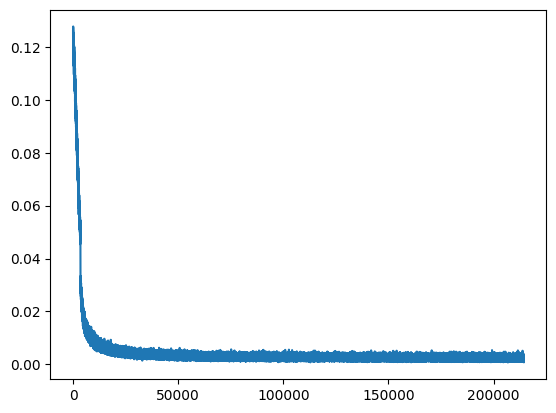

In [21]:
plt.plot(loss_history)

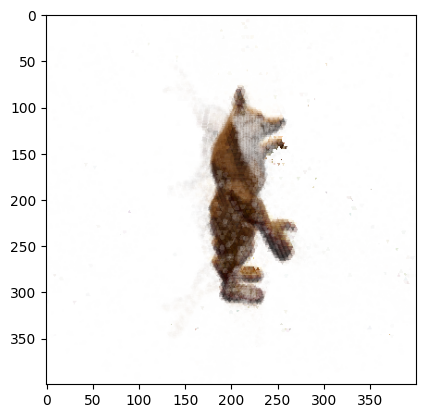

In [16]:
o_, d_ = create_rays(imgs[0], poses[0], intrinsics[0])
o_ = torch.from_numpy(o_).to(device=device)
d_ = torch.from_numpy(d_).to(device=device)

Ax = render(model, o_, d_, tn, tf, num_bins, device=device)
plt.imshow(Ax.reshape(H, W, 3).data.cpu().numpy())

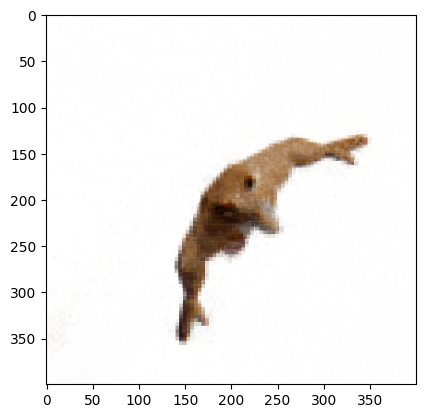

In [20]:
o_, d_ = create_rays(imgs[1], poses[1], intrinsics[1])
o_ = torch.from_numpy(o_).to(device=device)
d_ = torch.from_numpy(d_).to(device=device)

Ax = render(model, o_, d_, tn, tf, num_bins, device=device)
plt.imshow(Ax.reshape(H, W, 3).data.cpu().numpy())

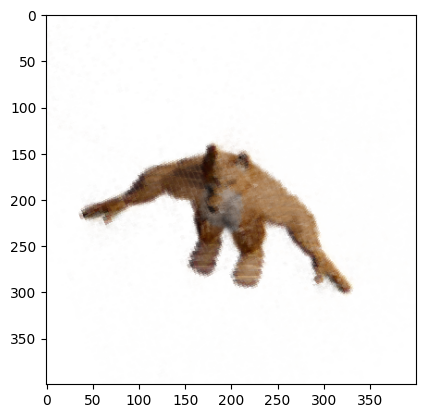

In [19]:
o_, d_ = create_rays(imgs[2], poses[2], intrinsics[2])
o_ = torch.from_numpy(o_).to(device=device)
d_ = torch.from_numpy(d_).to(device=device)

Ax = render(model, o_, d_, tn, tf, num_bins, device=device)
plt.imshow(Ax.reshape(H, W, 3).data.cpu().numpy())